# Python 2D Navier-stokes simulation

Taken from Lorena Barba

In [230]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math

In [231]:
nx = 20
ny = 20
nt = 1000

rho = 1
nu = .1
dt = .005

start_time = 0
end_time = dt * nt

nit = 50

dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 20, nx)
y = np.linspace(0, 20, ny)
X, Y = np.meshgrid(x, y)

In [232]:
def cavity_flow(u, v, dt, dx, dy, p, rho, nu):
    un = u.copy()
    vn = v.copy()
    
    #Get new pressure component based on current u and v
    for q in range(nit):
        #Copy current P into pn at each iteration
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                        (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                        (2 * (dx**2 + dy**2)) -
                        dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                        (rho * (1 / dt * 
                        ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                        (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                        ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                        2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                        (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                        ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2)))

        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
    
    #Update U and V based on current U, V and P
    u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                    un[1:-1, 1:-1] * dt / dx *
                    (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                    vn[1:-1, 1:-1] * dt / dy *
                    (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                    dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                    nu * (dt / dx**2 *
                    (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                    dt / dy**2 *
                    (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

    v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                    un[1:-1, 1:-1] * dt / dx *
                    (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                    vn[1:-1, 1:-1] * dt / dy *
                    (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                    dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                    nu * (dt / dx**2 *
                    (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                    dt / dy**2 *
                    (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

    #Update boundary conditions
    u[0, :]  = 0
    u[:, 0]  = 0
    u[:, -1] = 0
    u[-1, :] = 1    # set velocity on cavity lid equal to 1
    
    v[0, :]  = 0
    v[-1, :] = 0
    v[:, 0]  = 0
    v[:, -1] = 0
        
    return u, v, p

In [233]:
u_full = np.zeros((ny, nx, int(nt)))
v_full = np.zeros((ny, nx, int(nt)))
p_full = np.zeros((ny, nx, int(nt)))

for n in range(nt):
    if n == 0:
        u_full[:,:,n], v_full[:,:,n], p_full[:,:,n] = \
            cavity_flow(u_full[:,:,n], v_full[:,:,n], dt, dx, dy, p_full[:,:,n], rho, nu)
    
    else:
        u_full[:,:,n], v_full[:,:,n], p_full[:,:,n] = \
            cavity_flow(u_full[:,:,n-1], v_full[:,:,n-1], dt, dx, dy, p_full[:,:,n-1], rho, nu)

Animation write interval: 20
OpenFOAM outputs: 1000
OpenFOAM start-end(dt): 0-5.0(0.005)
# of animation frames: 50
OpenFOAM timesteps in animation: range(0, 1000, 20)


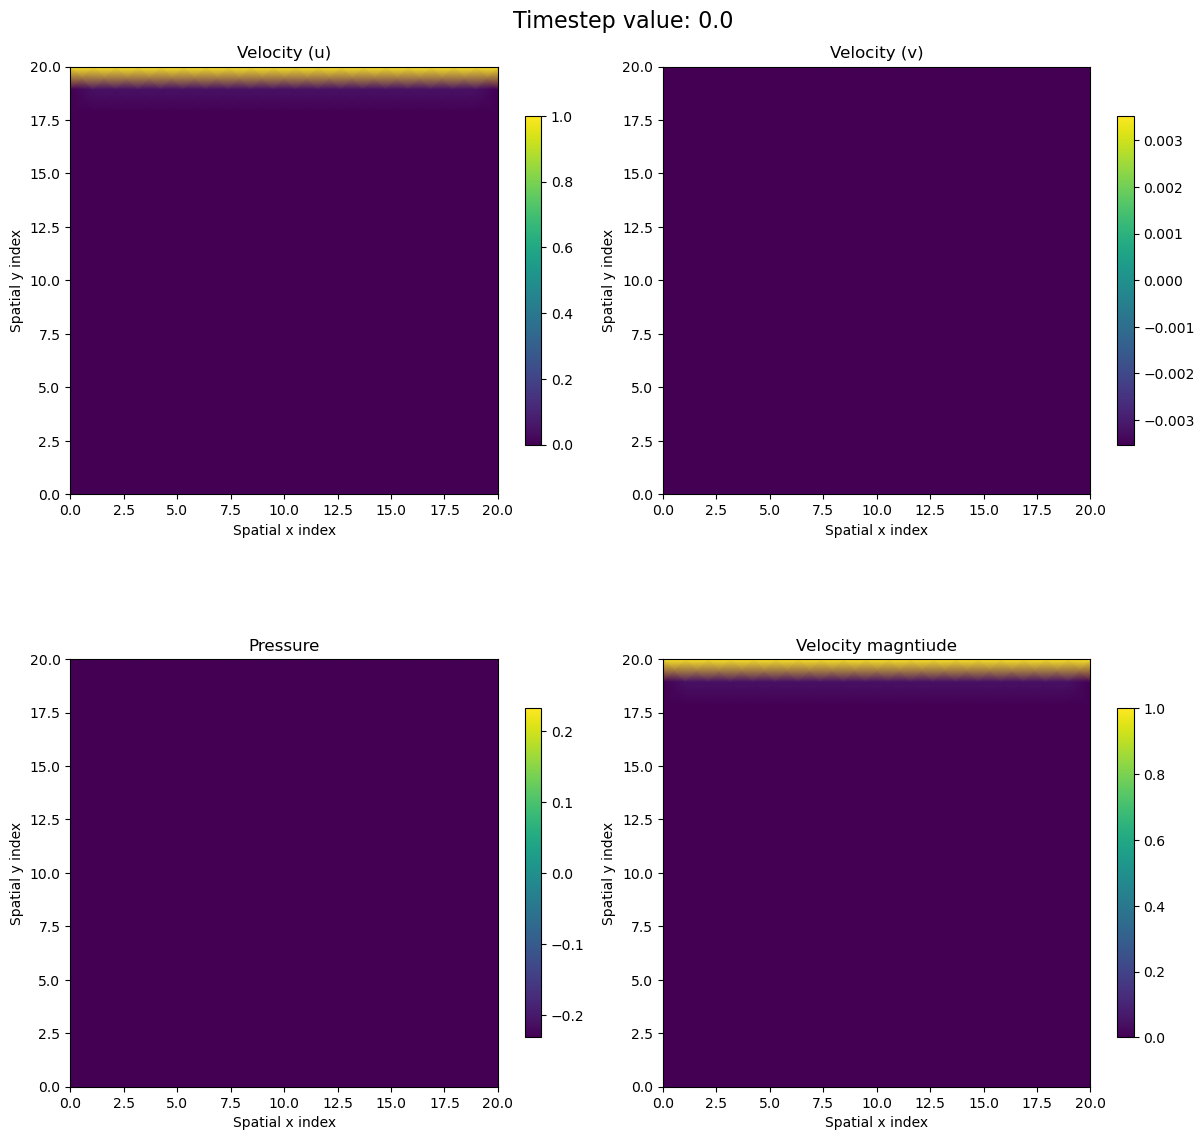

In [234]:
#QC training/testing selection with GIF using additional scatter ontop of quiver...will that work?
#Takes about 1.5 minutes to compute

#Decimate the timesteps for GIF output to avoid huge files and long creation time
animation_num_frames = 50
animation_write_interval = int(math.floor(nt / animation_num_frames))
print(f"Animation write interval: {animation_write_interval}")
print(f"OpenFOAM outputs: {nt}")
print(f"OpenFOAM start-end(dt): {start_time}-{end_time}({dt})")
print(f"# of animation frames: {animation_num_frames}")
print(f"OpenFOAM timesteps in animation: {range(0,int(nt),animation_write_interval)}")

fig, ax = plt.subplots(2,2, figsize=(12, 12))
fig.tight_layout()

#Compute magnitude of velocity
u_mag_full = np.sqrt(u_full.astype(np.double)**2 + v_full.astype(np.double)**2).astype(float)

#Use first timestep after initial condition to set the colour bar
fig.colorbar(ax[0][0].pcolormesh(X,Y, u_full[:,:,1], shading='gouraud'), shrink=0.6, orientation='vertical')
fig.colorbar(ax[0][1].pcolormesh(X,Y, v_full[:,:,1], shading='gouraud'), shrink=0.6, orientation='vertical')
fig.colorbar(ax[1][0].pcolormesh(X,Y, p_full[:,:,1], shading='gouraud'), shrink=0.6, orientation='vertical')
fig.colorbar(ax[1][1].pcolormesh(X,Y, u_mag_full[:,:,1], shading='gouraud'), shrink=0.6, orientation='vertical')

def animate_subplot(i):
    #Indexing values for plotting and GIF creation
    timestep_index = animation_write_interval * i
    timestep_time = timestep_index * dt

    fig.suptitle(f"Timestep value: {timestep_time}", fontsize=16)

    ax[0][0].pcolormesh(X,Y, u_full[:,:,timestep_index], shading='gouraud')

    if timestep_index != 0:
        ax[0][0].quiver(X,Y, u_full[:,:,timestep_index],v_full[:,:,timestep_index])

    ax[0][0].set_title("Velocity (u)")
    ax[0][0].set_ylabel("Spatial y index")
    ax[0][0].set_xlabel("Spatial x index")
    ax[0][0].set_box_aspect(1)

    ax[0][1].pcolormesh(X,Y, v_full[:,:,timestep_index], shading='gouraud')
    if timestep_index != 0:
        ax[0][1].quiver(X,Y, u_full[:,:,timestep_index],v_full[:,:,timestep_index])

    ax[0][1].set_title("Velocity (v)")
    ax[0][1].set_ylabel("Spatial y index")
    ax[0][1].set_xlabel("Spatial x index")
    ax[0][1].set_box_aspect(1)

    ax[1][0].pcolormesh(X,Y, p_full[:,:,timestep_index], shading='gouraud')
    if timestep_index != 0:
        ax[1][0].quiver(X,Y, u_full[:,:,timestep_index],v_full[:,:,timestep_index])

    ax[1][0].set_title("Pressure")
    ax[1][0].set_ylabel("Spatial y index")
    ax[1][0].set_xlabel("Spatial x index")
    ax[1][0].set_box_aspect(1)

    ax[1][1].pcolormesh(X,Y, u_mag_full[:,:,timestep_index], shading='gouraud')
    if timestep_index != 0:
        ax[1][1].quiver(X,Y, u_full[:,:,timestep_index],v_full[:,:,timestep_index])

    ax[1][1].set_title("Velocity magntiude")
    ax[1][1].set_ylabel("Spatial y index")
    ax[1][1].set_xlabel("Spatial x index")
    ax[1][1].set_box_aspect(1)

save_animation=True
if save_animation == True:
    ani = animation.FuncAnimation(fig, animate_subplot, int(animation_num_frames), interval=1)
    writervideo = animation.FFMpegWriter(fps=20)
    ani.save(f'full_python_outputframes{animation_num_frames}.mp4',writer=writervideo)